# Fashion‑MNIST Classification Project
## Comparison of Convolutional Neural Networks and Random Forests

### Abstract
This project investigates the classification of fashion products using the Fashion‑MNIST dataset. Two machine learning approaches are evaluated: a Convolutional Neural Network (CNN) and a Random Forest classifier. The models are trained and tested on grayscale images belonging to ten fashion categories. Performance is assessed using accuracy, confusion matrices, and precision‑recall metrics. The results demonstrate that the CNN outperforms the Random Forest classifier, particularly for visually similar clothing categories, due to its ability to learn spatial features from image data.

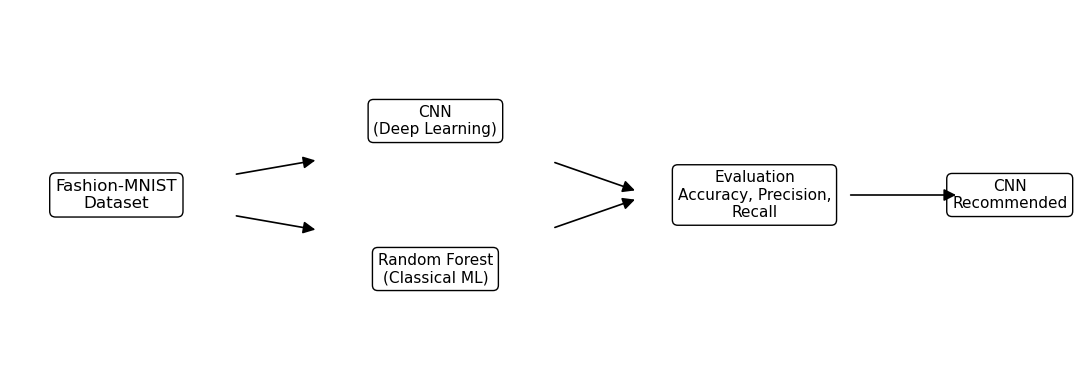

In [2]:
# Display graphical abstract illustrating the classification pipeline and model comparison.
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(11, 4))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis("off")

box_kw = dict(boxstyle="round,pad=0.35", ec="black", fc="white")

# ---- Boxes ----
ax.text(0.10, 0.50, "Fashion‑MNIST\nDataset",
        ha="center", va="center", fontsize=12, bbox=box_kw, zorder=3)

ax.text(0.40, 0.70, "CNN\n(Deep Learning)",
        ha="center", va="center", fontsize=11, bbox=box_kw, zorder=3)

ax.text(0.40, 0.30, "Random Forest\n(Classical ML)",
        ha="center", va="center", fontsize=11, bbox=box_kw, zorder=3)

ax.text(0.70, 0.50, "Evaluation\nAccuracy, Precision,\nRecall",
        ha="center", va="center", fontsize=11, bbox=box_kw, zorder=3)

# Move this slightly right so the final arrow has room for its head
ax.text(0.94, 0.50, "CNN\nRecommended",
        ha="center", va="center", fontsize=11, bbox=box_kw, zorder=3)

# ---- Arrow helper ----
def draw_arrow(xytext, xy, shrinkA=10, shrinkB=10, zorder=2):
    ax.annotate(
        "", xy=xy, xytext=xytext,
        xycoords="axes fraction", textcoords="axes fraction",
        arrowprops=dict(
            arrowstyle="-|>",        # strong visible arrowhead
            lw=1.2,
            color="black",
            mutation_scale=18,       # head size
            shrinkA=shrinkA,
            shrinkB=shrinkB
        ),
        zorder=zorder,
        clip_on=False
    )

# ---- Arrows ----
draw_arrow((0.20, 0.55), (0.30, 0.60))
draw_arrow((0.20, 0.45), (0.30, 0.40))
draw_arrow((0.50, 0.60), (0.60, 0.50))
draw_arrow((0.50, 0.40), (0.60, 0.50))

# Final arrow: give it length + small shrink at head, and draw above boxes
draw_arrow((0.78, 0.50), (0.90, 0.50), shrinkA=8, shrinkB=8, zorder=5)

plt.tight_layout()
plt.show()

## 1. Introduction

Image classification is a fundamental problem in computer vision, with applications ranging from retail and e‑commerce to medical imaging. In the fashion retail industry, automatic classification of clothing items can improve inventory management, product search, and recommendation systems.

This project focuses on the Fashion‑MNIST dataset, a benchmark dataset introduced by Zalando as a more challenging alternative to the original MNIST dataset. The goal is to evaluate and compare two different classification approaches: a deep learning model (CNN) and a classical machine learning model (Random Forest).

In [4]:
# Import necessary modules and libraries
import tensorflow as tf
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D,
    Flatten, Dense, Dropout
)
from tensorflow.keras.utils import plot_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import gzip
import numpy as np
import pandas as pd
import requests
import time
import gdown

## 2. Dataset Description

The Fashion‑MNIST dataset consists of 70,000 grayscale images of fashion products, each with a resolution of 28×28 pixels. The dataset contains 10 balanced classes, including T‑shirts, trousers, dresses, footwear, and accessories.

- Training set: 60,000 images
- Test set: 10,000 images
- Number of classes: 10

Each image is associated with a single class label ranging from 0 to 9.

## 3. Data Loading and Preprocessing

The Fashion‑MNIST dataset is provided in IDX format and compressed using GZIP. Custom functions are implemented to read image and label files directly from their binary format.

Preprocessing steps include:
- Normalization of pixel values to the range [0, 1]
- Adding a channel dimension for CNN compatibility
- Reshaping images for Random Forest classification

In [7]:
# Download data files using gdown
files = {
    "t10k-images.gz": "1alVipRcs--j42KPjypzifzcaTcNru0BE",
    "t10k-labels.gz": "1Dz1H0bYJ9yqgQPagxoRWU25VgA36mntM",
    "train-images.gz": "1QsLSGIYZ-z_dGTBq8MSBsr0KeSOpwB5b",
    "train-labels.gz": "1STE48eAaYBgIJmZOD-1qp3kSdZhOPx6O",
}

for out, fid in files.items():
    gdown.download(f"https://drive.google.com/uc?id={fid}", out, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1alVipRcs--j42KPjypzifzcaTcNru0BE
To: C:\Users\User\Downloads\t10k-images.gz
100%|█████████████████████████████████████████████████████████████████████████████| 4.42M/4.42M [00:01<00:00, 2.41MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Dz1H0bYJ9yqgQPagxoRWU25VgA36mntM
To: C:\Users\User\Downloads\t10k-labels.gz
100%|█████████████████████████████████████████████████████████████████████████████| 5.15k/5.15k [00:00<00:00, 5.17MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QsLSGIYZ-z_dGTBq8MSBsr0KeSOpwB5b
From (redirected): https://drive.google.com/uc?id=1QsLSGIYZ-z_dGTBq8MSBsr0KeSOpwB5b&confirm=t&uuid=e37af0d4-60f1-4a63-b623-203a6f0f1af4
To: C:\Users\User\Downloads\train-images.gz
100%|█████████████████████████████████████████████████████████████████████████████| 26.4M/26.4M [00:10<00:00, 2.60MB/s]
Downloading...
From: https://drive.google.com/uc?id=1STE48eAaYBgIJmZOD-1qp3kSdZhOPx6O
To: C:\Users\User\D

In [8]:
# Define a function to load images
def load_images(path):
    with gzip.open(path, 'rb') as f:
        data = f.read()

    # IDX image file format
    magic = int.from_bytes(data[0:4], 'big')
    num_images = int.from_bytes(data[4:8], 'big')
    rows = int.from_bytes(data[8:12], 'big')
    cols = int.from_bytes(data[12:16], 'big')

    images = np.frombuffer(data[16:], dtype=np.uint8)
    images = images.reshape(num_images, rows, cols)

    return images

In [9]:
# Define a function to load labels
def load_labels(path):
    with gzip.open(path, 'rb') as f:
        data = f.read()

    # IDX image file format
    magic = int.from_bytes(data[0:4], 'big')
    num_images = int.from_bytes(data[4:8], 'big')

    labels = np.frombuffer(data[8:], dtype=np.uint8)

    return labels

In [10]:
# Split image and labels data into training and test sets
x_train = load_images("train-images.gz")
y_train = load_labels("train-labels.gz")

x_test = load_images("t10k-images.gz")
y_test = load_labels("t10k-labels.gz")

In [11]:
# Display shape of split data
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [12]:
# Normalize
x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# Add channel dimension
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

## 4. Exploratory Data Analysis

To gain an intuitive understanding of the dataset, sample images from the training set are visualized along with their corresponding labels. This step helps confirm correct data loading and highlights the visual similarity between certain clothing categories.

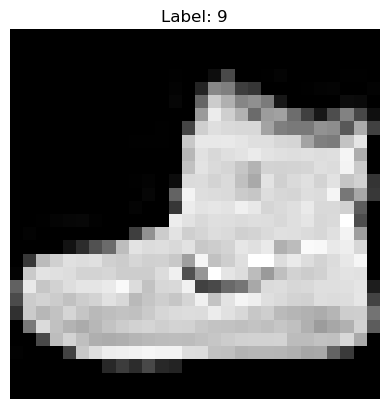

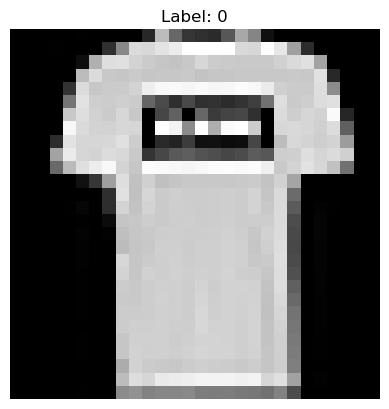

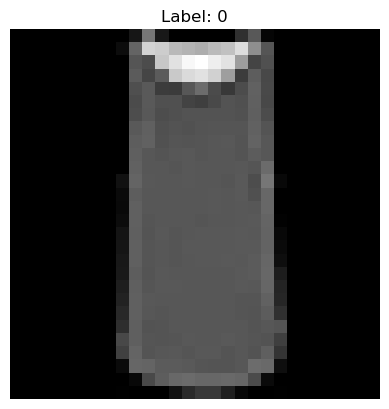

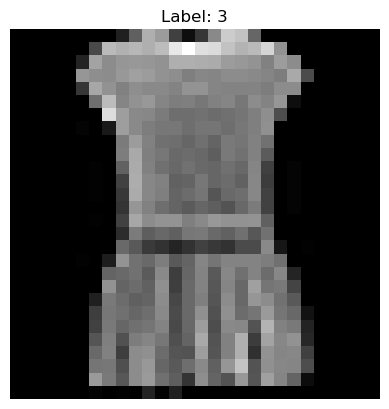

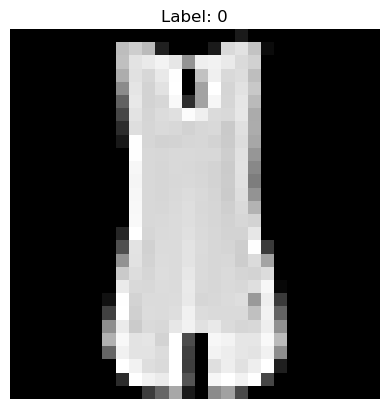

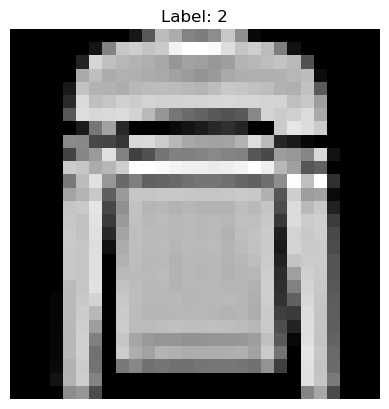

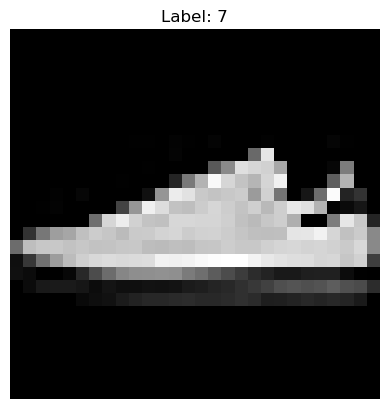

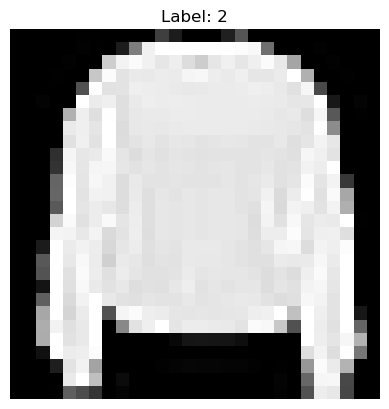

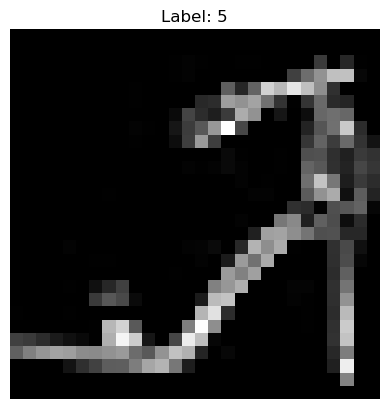

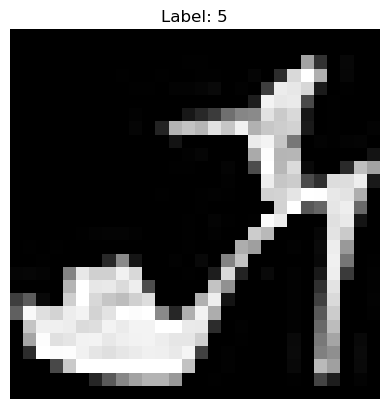

In [14]:
# Display 10 items from the dataset (images and labels)
for i in range(10):

    plt.imshow(x_train[i].squeeze(), cmap='gray')
    plt.title(f"Label: {y_train[i]}")
    plt.axis('off')

    plt.show()

## 5. Convolutional Neural Network (CNN)

A Convolutional Neural Network is used to exploit the spatial structure of image data. CNNs are particularly well‑suited for image classification tasks due to their ability to learn hierarchical feature representations, such as edges, shapes, and textures.

In [16]:
# Instantiate CNN architecture
model = Sequential([
    Input(shape=(28, 28, 1)),
    
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),

    Dense(10, activation='softmax')
])

In [17]:
# Compile CNN
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [18]:
# Display summary of CNN model
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

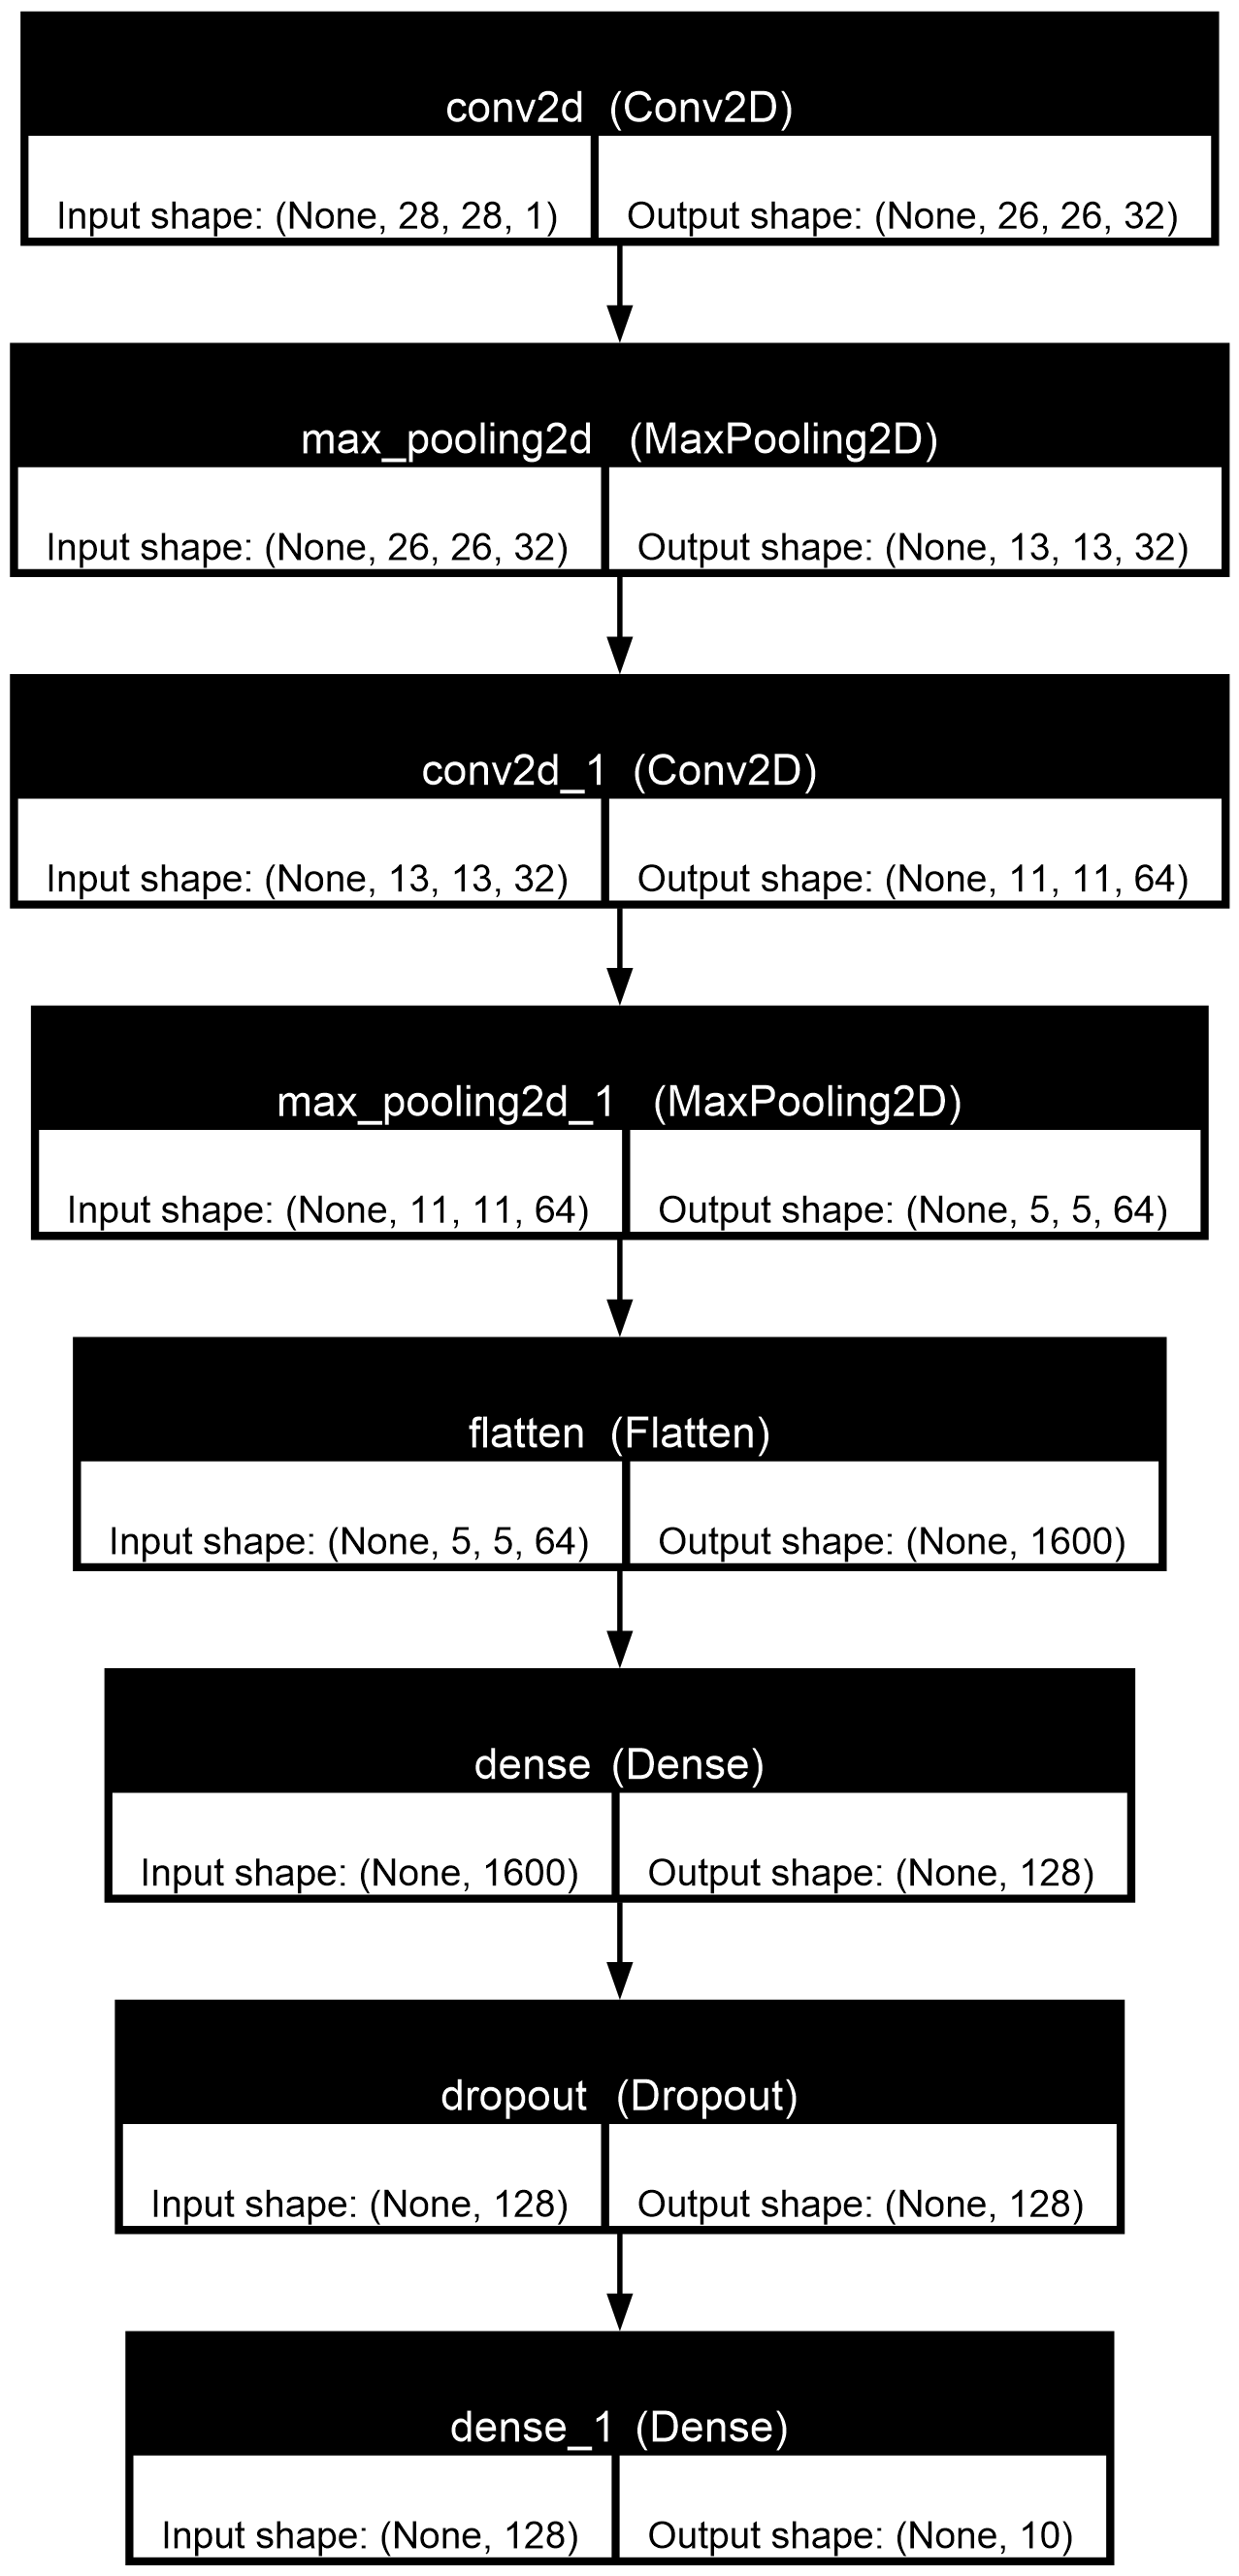

In [19]:
# Generate image of CNN model architecture
plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    to_file="cnn_architecture.png"
)

### 5.1 CNN Architecture

The CNN architecture consists of two convolutional layers followed by max‑pooling layers, a fully connected dense layer, and a softmax output layer. Dropout is applied to reduce overfitting. The model is trained using the Adam optimizer and sparse categorical cross‑entropy loss.

In [21]:
# Split training data further into training subsets as well as validation sets
x_train_sub, x_val, y_train_sub, y_val = train_test_split(
    x_train, y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

In [22]:
# Train CNN model while also measuring how long the process takes
start_time=time.time()

history = model.fit(
    x_train_sub, y_train_sub,
    epochs=10,
    batch_size=128,
    validation_data=(x_val, y_val),
    verbose=1
)

end_time = time.time()

training_time = end_time - start_time

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 34ms/step - accuracy: 0.6620 - loss: 0.9473 - val_accuracy: 0.8508 - val_loss: 0.4014
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.8345 - loss: 0.4589 - val_accuracy: 0.8823 - val_loss: 0.3309
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8592 - loss: 0.3925 - val_accuracy: 0.8903 - val_loss: 0.3036
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8729 - loss: 0.3495 - val_accuracy: 0.8990 - val_loss: 0.2803
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8855 - loss: 0.3220 - val_accuracy: 0.9002 - val_loss: 0.2669
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 35ms/step - accuracy: 0.8895 - loss: 0.3026 - val_accuracy: 0.9045 - val_loss: 0.2609
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 16s 37ms/step - accuracy: 0.8957 - loss: 0.2860 - val_accuracy: 0.9107 - val_loss: 0.2499
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 15s 36ms/step - accuracy: 0.8987 - loss: 0.2725 - 

In [23]:
# Display CNN model training time
print(f"CNN training time:\n{training_time:.2f} seconds.")

CNN training time:
160.33 seconds.


<Figure size 1200x400 with 0 Axes>

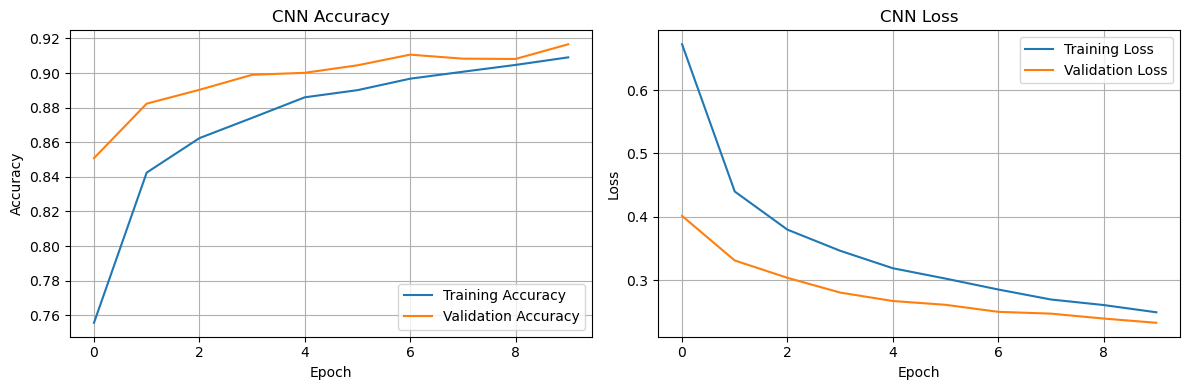

In [24]:
# Plot curves for CNN model accuracy (training and validation) and loss (training and validation)
plt.figure(figsize=(12, 4))

plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('CNN Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 5.2 CNN Training Analysis

Training and validation curves show a steady increase in accuracy and a corresponding decrease in loss. The close alignment between training and validation performance indicates good generalization and minimal overfitting.

### CNN Evaluation on Training Set

CNN training accuracy (train split): 0.9288


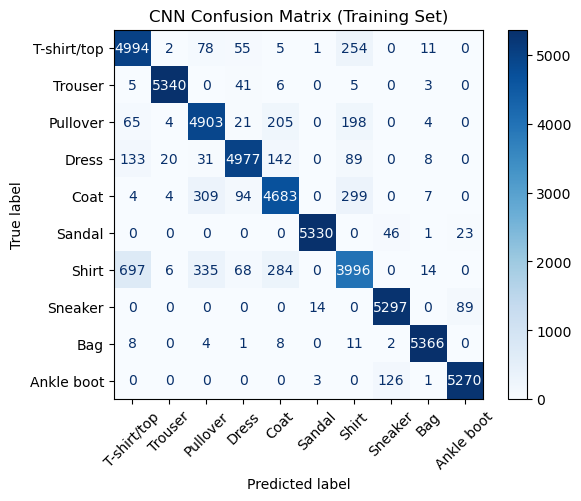

,precision,recall,f1-score,support
T-shirt/top,0.845581,0.924815,0.883425,5400.000000
Trouser,0.993304,0.988889,0.991091,5400.000000
Pullover,0.866254,0.907963,0.886618,5400.000000
Dress,0.946738,0.921667,0.934034,5400.000000
Coat,0.878117,0.867222,0.872636,5400.000000
Sandal,0.996634,0.987037,0.991812,5400.000000
Shirt,0.823578,0.740000,0.779555,5400.000000
Sneaker,0.968196,0.980926,0.974519,5400.000000
Bag,0.990951,0.993704,0.992325,5400.000000
Ankle boot,0.979190,0.975926,0.977555,5400.000000


In [27]:
# CNN evaluation on TRAINING set (training split used during fitting)

class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

y_pred_probs_train = model.predict(x_train_sub, verbose=0)
y_pred_train = np.argmax(y_pred_probs_train, axis=1)

train_accuracy = accuracy_score(y_train_sub, y_pred_train)
print(f"CNN training accuracy (train split): {train_accuracy:.4f}")

cm_train = confusion_matrix(y_train_sub, y_pred_train)
disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=class_names)
disp_train.plot(cmap='Blues', xticks_rotation=45)
plt.title('CNN Confusion Matrix (Training Set)')
plt.show()

report_train = classification_report(
    y_train_sub,
    y_pred_train,
    output_dict=True,
    target_names=class_names
)

df_report_train = pd.DataFrame(report_train).transpose()
df_report_train

In [28]:
# Display CNN model accuracy and loss metrics on the test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

print(f"Test loss: {test_loss:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")

Test loss: 0.2593
Test accuracy: 0.9047


In [29]:
# Generate probabilities and  predictions for image classification on the test set
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


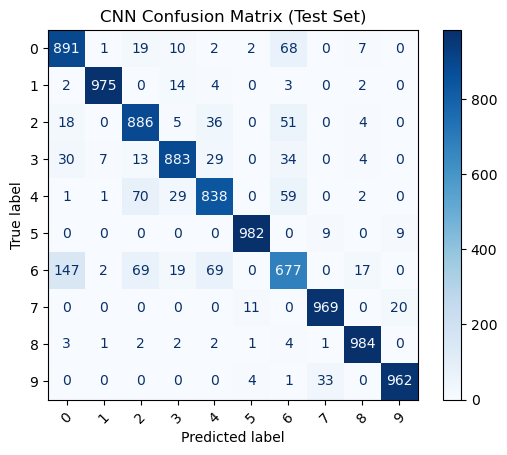

In [30]:
# Display confusion matrix for CNN model
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('CNN Confusion Matrix (Test Set)')
plt.show()

In [31]:
# Generate and display classification report DataFrame for CNN model
report = classification_report(
    y_test,
    y_pred,
    output_dict=True,
    target_names=[
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
)

df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
T-shirt/top,0.815934,0.8910,0.851816,1000.0000
Trouser,0.987842,0.9750,0.981379,1000.0000
Pullover,0.836638,0.8860,0.860612,1000.0000
Dress,0.917879,0.8830,0.900102,1000.0000
Coat,0.855102,0.8380,0.846465,1000.0000
Sandal,0.982000,0.9820,0.982000,1000.0000
Shirt,0.754738,0.6770,0.713759,1000.0000
Sneaker,0.957510,0.9690,0.963221,1000.0000
Bag,0.964706,0.9840,0.974257,1000.0000
Ankle boot,0.970737,0.9620,0.966349,1000.0000


### 5.3 CNN Evaluation

The CNN achieves strong performance on the test set, particularly for footwear and accessory categories. However, lower performance is observed for visually similar upper‑body garments such as shirts and T‑shirts, which are frequently confused due to overlapping shapes and textures.

## 6. Random Forest Classifier

To provide a baseline comparison, a Random Forest classifier is trained on the same dataset. Since Random Forests do not inherently handle image data, each image is flattened into a one‑dimensional feature vector.

In [34]:
# Flatten 28x28 images into 784‑dim vectors
x_train_rf = x_train.reshape(x_train.shape[0], -1)
x_test_rf = x_test.reshape(x_test.shape[0], -1)

In [35]:
# Instantiate Random Forest model
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    n_jobs=1,
    random_state=42
)

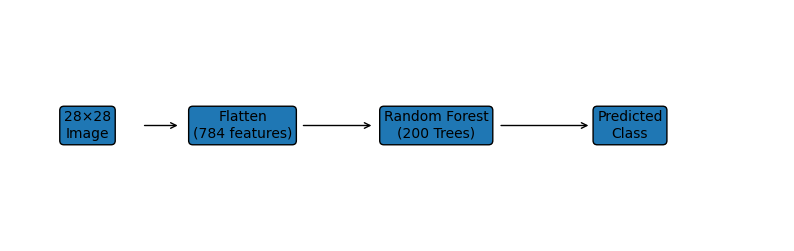

In [36]:
# Display Random Forest classification pipeline after feature flattening
fig, ax = plt.subplots(figsize=(10, 3))
ax.axis('off')

ax.text(0.1, 0.5, "28×28\nImage", ha='center', va='center',
        bbox=dict(boxstyle="round"))

ax.text(0.3, 0.5, "Flatten\n(784 features)", ha='center', va='center',
        bbox=dict(boxstyle="round"))

ax.text(0.55, 0.5, "Random Forest\n(200 Trees)", ha='center', va='center',
        bbox=dict(boxstyle="round"))

ax.text(0.8, 0.5, "Predicted\nClass", ha='center', va='center',
        bbox=dict(boxstyle="round"))

ax.annotate("", xy=(0.22, 0.5), xytext=(0.17, 0.5), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.47, 0.5), xytext=(0.375, 0.5), arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0.75, 0.5), xytext=(0.63, 0.5), arrowprops=dict(arrowstyle="->"))

plt.show()

In [37]:
# Train Random Forest model while also measuring how long the process takes
start_time = time.time()

rf.fit(x_train_rf, y_train)

end_time = time.time()

training_time_rf = end_time - start_time

In [38]:
# Display Random Forest model training time
print(f"Random Forest training time:\n{training_time_rf:.2f} seconds.")

Random Forest training time:
212.08 seconds.


### Random Forest Evaluation on Training Set

Random Forest training accuracy: 1.0000


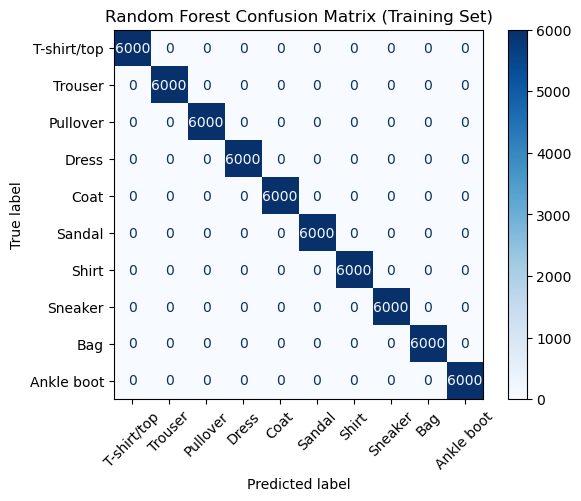

,precision,recall,f1-score,support
T-shirt/top,1.0,1.0,1.0,6000.0
Trouser,1.0,1.0,1.0,6000.0
Pullover,1.0,1.0,1.0,6000.0
Dress,1.0,1.0,1.0,6000.0
Coat,1.0,1.0,1.0,6000.0
Sandal,1.0,1.0,1.0,6000.0
Shirt,1.0,1.0,1.0,6000.0
Sneaker,1.0,1.0,1.0,6000.0
Bag,1.0,1.0,1.0,6000.0
Ankle boot,1.0,1.0,1.0,6000.0


In [40]:
# Random Forest evaluation on TRAINING set

y_pred_rf_train = rf.predict(x_train_rf)

train_accuracy_rf = accuracy_score(y_train, y_pred_rf_train)
print(f"Random Forest training accuracy: {train_accuracy_rf:.4f}")

cm_rf_train = confusion_matrix(y_train, y_pred_rf_train)
disp_rf_train = ConfusionMatrixDisplay(confusion_matrix=cm_rf_train, display_labels=class_names)
disp_rf_train.plot(cmap='Blues', xticks_rotation=45)
plt.title('Random Forest Confusion Matrix (Training Set)')
plt.show()

report_rf_train = classification_report(
    y_train,
    y_pred_rf_train,
    output_dict=True,
    target_names=class_names
)

df_report_rf_train = pd.DataFrame(report_rf_train).transpose()
df_report_rf_train

In [41]:
# Display Random Forest model accuracy score
y_pred_rf = rf.predict(x_test_rf)

accuracy_rf = accuracy_score(y_test, y_pred_rf)

print(f"Random Forest accuracy score:\n{accuracy_rf}")

Random Forest accuracy score:
0.8779


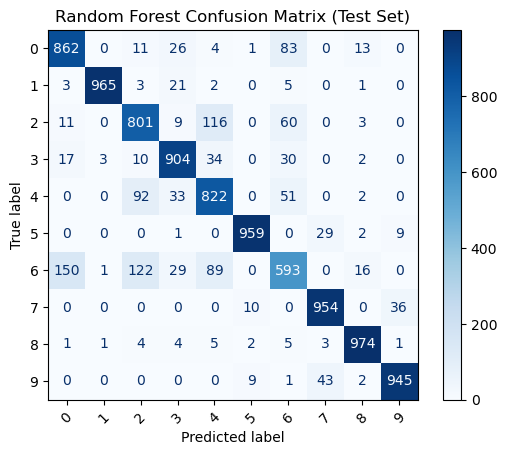

In [42]:
# Display confusion matrix for Random Forest model
cm_rf = confusion_matrix(y_test, y_pred_rf)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Random Forest Confusion Matrix (Test Set)")
plt.show()

In [43]:
# Generate and display classification report DataFrame for Random Forest model
report_rf = classification_report(
    y_test,
    y_pred_rf,
    output_dict=True,
    target_names=[
        'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
    ]
)

df_report_rf = pd.DataFrame(report_rf).transpose()
df_report_rf

,precision,recall,f1-score,support
T-shirt/top,0.825670,0.8620,0.843444,1000.0000
Trouser,0.994845,0.9650,0.979695,1000.0000
Pullover,0.767977,0.8010,0.784141,1000.0000
Dress,0.880234,0.9040,0.891959,1000.0000
Coat,0.766791,0.8220,0.793436,1000.0000
Sandal,0.977574,0.9590,0.968198,1000.0000
Shirt,0.716184,0.5930,0.648796,1000.0000
Sneaker,0.927114,0.9540,0.940365,1000.0000
Bag,0.959606,0.9740,0.966749,1000.0000
Ankle boot,0.953582,0.9450,0.949272,1000.0000


### 6.1 Random Forest Evaluation

The Random Forest classifier achieves reasonable accuracy but performs worse than the CNN across most classes. The lack of spatial feature learning results in increased confusion between visually similar categories, particularly upper‑body clothing.

## 7. Model Comparison

A direct comparison between the CNN and Random Forest classifiers highlights the advantages of deep learning for image‑based tasks. While the Random Forest provides a strong classical baseline, the CNN consistently achieves higher accuracy, better recall for difficult classes, and shorter training time in this implementation.

In [46]:
# Summary comparison table (train + test)

# CNN test metrics are already stored in: test_accuracy, report
# RF test metrics are already stored in: accuracy_rf, report_rf

summary_df = pd.DataFrame([
    {
        "Model": "CNN",
        "Train Accuracy": train_accuracy,
        "Test Accuracy": test_accuracy,
        "Train Precision (weighted)": report_train["weighted avg"]["precision"],
        "Train Recall (weighted)": report_train["weighted avg"]["recall"],
        "Test Precision (weighted)": report["weighted avg"]["precision"],
        "Test Recall (weighted)": report["weighted avg"]["recall"],
        "Training Time (s)": training_time
    },
    {
        "Model": "Random Forest",
        "Train Accuracy": train_accuracy_rf,
        "Test Accuracy": accuracy_rf,
        "Train Precision (weighted)": report_rf_train["weighted avg"]["precision"],
        "Train Recall (weighted)": report_rf_train["weighted avg"]["recall"],
        "Test Precision (weighted)": report_rf["weighted avg"]["precision"],
        "Test Recall (weighted)": report_rf["weighted avg"]["recall"],
        "Training Time (s)": training_time_rf
    }
])

summary_df

,Model,Train Accuracy,Test Accuracy,Train Precision (weighted),Train Recall (weighted),Test Precision (weighted),Test Recall (weighted),Training Time (s)
0,CNN,0.928815,0.9047,0.928854,0.928815,0.904309,0.9047,160.334709
1,Random Forest,1.000000,0.8779,1.000000,1.000000,0.876958,0.8779,212.079600


## 8. Conclusion and Recommendation

This project compared a Convolutional Neural Network and a Random Forest classifier for fashion image classification. Experimental results show that the CNN outperforms the Random Forest in terms of accuracy, class‑wise recall, and robustness to visually similar categories.

Based on these findings, the CNN is recommended for production use in fashion product classification systems, as it better captures spatial information and scales more effectively to complex visual tasks.